In [90]:
# Great Articles by Javier Ideami - must read
# https://towardsdatascience.com/coding-a-2-layer-neural-network-from-scratch-in-python-4dd022d19fd2
# https://towardsdatascience.com/predict-malignancy-in-breast-cancer-tumors-with-your-own-neural-network-and-the-wisconsin-dataset-76271a05e941
# https://github.com/javismiles/Deep-Learning-predicting-breast-cancer-tumor-malignancy
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools

In [91]:
# X input variable
# Y output variable
# Yh: Holds the output that our network produces. It should have the same dimensions than Y, our desired target values. We initialize it to zero
# L = layers
# dims = how many neurons are there in each layer - 1 layer has 9, 2nd one has 15 adn 3rd has 1.
# param : W and b for each layer
# ch: a cache variable, a python dictionary that will hold some intermediate calculations that we will need during the backward pass of the gradient descent algorithm.
# sam: The number of training samples we have.
# loss: An array where we will store the loss value of the network every x iterations
# calculating activation function
def Sigmoid(Z):
    return 1/(1+np.exp(-Z))

def Relu(Z):
    return np.maximum(0,Z)

# for backpropogation, check the article metioned in first line.
def dRelu(x):
    x[x<=0] = 0
    x[x>0] = 1
    return x

def dSigmoid(Z):
    s = 1/(1+np.exp(-Z))
    dZ = s * (1-s)
    return dZ

class dlnet:
    def __init__(self, x, y):
        self.X=x
        self.Y=y
        self.Yh=np.zeros((1,self.Y.shape[1]))
        
        #check the confusion matrix cell
        self.threshold=0.9
        
        self.L=2
        self.dims = [9, 15, 1]
        self.param = {}
        self.ch = {}
        self.grad = {}
        self.loss = []
        self.lr=0.003
        self.sam = self.Y.shape[1]
        
    #initializing the weight and biases for both the layers.
    # W1: The number of rows is the number of hidden units of that layer, dims[1], and the number of columns is the number of features/rows of the previous layer (in this case X, our input data), dims[0].
    # b1: Same number of rows as W1 and a single column.
    def nInit(self):    
        np.random.seed(1)
        self.param['W1'] = np.random.randn(self.dims[1], self.dims[0]) / np.sqrt(self.dims[0]) 
        self.param['b1'] = np.zeros((self.dims[1], 1))        
        self.param['W2'] = np.random.randn(self.dims[2], self.dims[1]) / np.sqrt(self.dims[1]) 
        self.param['b2'] = np.zeros((self.dims[2], 1))                
        return

    # First we multily the inputs with weight W1(layer 1 weights) and add a bias,
    # so in W's first column will have all weight connection of 1st neuron to all the second layer neurons, and 2nd
    # column will have the weights of 2nd neuron to all the second layer.
    # so, to get the 1st neuron of 2nd layer, we are adding(weight * x) all previous layer neuron that are coming to that neurons.
    # then we apply the activation function on top of it.
    # we do the same for 2nd layer, but this time, we are multipying with it with the output we got it from previous
    # layer, i.e. W1
    # We just ran our input data through the network and produced Yh, an output.
    def forward(self):    
        Z1 = self.param['W1'].dot(self.X) + self.param['b1'] 
        A1 = Relu(Z1)
        self.ch['Z1'],self.ch['A1']=Z1,A1

        Z2 = self.param['W2'].dot(A1) + self.param['b2']  
        A2 = Sigmoid(Z2)
        self.ch['Z2'],self.ch['A2']=Z2,A2
        self.Yh=A2
        loss=self.nloss(A2)
        return self.Yh, loss

    # Cross-entropy is a great loss function for classification problems (like the one we will work on)
    # because it strongly penalizes predictions that are confident and yet wrong (like predicting with 
    # high confidence that a tumor is malign when in fact it is benign)
    def nloss(self,Yh):
        loss = (1./self.sam) * (-np.dot(self.Y,np.log(Yh).T) - np.dot(1-self.Y, np.log(1-Yh).T))    
        return loss
    
    
    def backward(self):
        dLoss_Yh = - (np.divide(self.Y, self.Yh ) - np.divide(1 - self.Y, 1 - self.Yh))    

        dLoss_Z2 = dLoss_Yh * dSigmoid(self.ch['Z2'])    
        dLoss_A1 = np.dot(self.param["W2"].T,dLoss_Z2)
        dLoss_W2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2,self.ch['A1'].T)
        dLoss_b2 = 1./self.ch['A1'].shape[1] * np.dot(dLoss_Z2, np.ones([dLoss_Z2.shape[1],1])) 

        dLoss_Z1 = dLoss_A1 * dRelu(self.ch['Z1'])        
        dLoss_A0 = np.dot(self.param["W1"].T,dLoss_Z1)
        dLoss_W1 = 1./self.X.shape[1] * np.dot(dLoss_Z1,self.X.T)
        dLoss_b1 = 1./self.X.shape[1] * np.dot(dLoss_Z1, np.ones([dLoss_Z1.shape[1],1]))  

        self.param["W1"] = self.param["W1"] - self.lr * dLoss_W1
        self.param["b1"] = self.param["b1"] - self.lr * dLoss_b1
        self.param["W2"] = self.param["W2"] - self.lr * dLoss_W2
        self.param["b2"] = self.param["b2"] - self.lr * dLoss_b2

    # defining gradient descent
    def gd(self,X, Y, iter = 3000):
        np.random.seed(1)                         
        self.nInit()
        for i in range(0, iter):
            Yh, loss=self.forward()
            self.backward()
            if i % 500 == 0:
                print ("Cost after iteration %i: %f" %(i, loss))
                self.loss.append(loss)
        return
    
    def pred(self,x, y):  
        self.X=x
        self.Y=y
        comp = np.zeros((1,x.shape[1]))
        pred, loss= self.forward()    

        for i in range(0, pred.shape[1]):
#            if pred[0,i] > 0.5: comp[0,i] = 1
            if pred[0,i] > self.threshold: comp[0,i] = 1
            else: comp[0,i] = 0

        print("Acc: " + str(np.sum((comp == y)/x.shape[1])))

        return comp

In [92]:
# The following 9 columns are features that express different types of information 
# connected to the detected tumors. They represent data related to: Clump Thickness, 
# Uniformity of Cell Size, Uniformity of Cell Shape, Marginal Adhesion, Single Epithelial Cell Size,
# Bare Nuclei, Bland Chromatin, Normal Nucleoli and Mitoses.

# The last column is the class of the tumor and it has two possible values: 2 means that the tumor was
# found to be benign. 4 means that it was found to be malignant.

# The input to the network will be made of the 9 features, the 9 columns that express different features
# of the tumors.

df = pd.read_csv('breast-cancer-wisconsin.csv',header=None)
df.head(5)

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [93]:
#We proceed to do these changes. First, we change the class values (at the column number 10) 
# from 2 to 0 and from 4 to 1
df.iloc[:,10].replace(2, 0,inplace=True)
df.iloc[:,10].replace(4, 1,inplace=True)
# Then we proceed to eliminate all rows that hold missing values (represented by the ? character) at
# column 6, which we have identified as the column that holds them.
df = df[~df[6].isin(['?'])]
# converting dataframe to float
df = df.astype(float)

In [94]:
#Data normalization is a key first step within the feature engineering phase of deep learning processes.
# so that all data will come btw 0 to 1 range.
names = df.columns[0:10]
scaler = MinMaxScaler() 
scaled_df = scaler.fit_transform(df.iloc[:,0:10]) 
scaled_df = pd.DataFrame(scaled_df, columns=names)

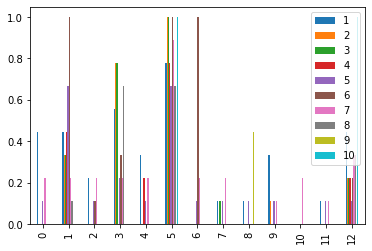

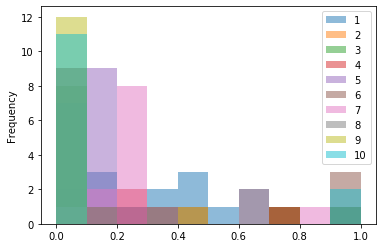

In [95]:
# Then we have to check, whether all the 9 features are useful or not.
scaled_df[10]= df[10]
scaled_df.iloc[0:13,1:11].plot.bar();
scaled_df.iloc[0:13,1:11].plot.hist(alpha=0.5)

In [96]:
#three sets of data :
#Deep learning practitioner typically takes into account three kinds of data-sets:
#Training set: the data you use to train the network. It contains the input features and the target labels.
#Validation set: a separate, different batch of data, which should ideally come from the same distribution
# than the training set. You will use it to verify the quality of the training. The validation set has as well
#target labels.
#Test set: another separate batch of data, used to test the network with fresh related data that ideally comes
#from the same distribution than the validation set. Typically, the test set doesn’t come with target labels.
#***** To estimate the quality of the training of your network, it is useful to compare the performance of
#your training and validation sets:
# Ideally you want to get similar performance in both data-sets - loss value achieved on the validation set
# improves and then starts to get worse, the network is over-fitting
# The opposite of over-fitting is under-fitting, when the training performance of the network is not good enough
# and we obtain loss values that are too high in both the training and validation sets

# In general, realize that success with the validation set is your real target.

# diving the data into training and validation set, notice we removed first column as it is a patient ID
x=scaled_df.iloc[0:500,1:10].values.transpose()
y=df.iloc[0:500,10:].values.transpose()

xval=scaled_df.iloc[501:683,1:10].values.transpose()
yval=df.iloc[501:683,10:].values.transpose()

In [97]:
nn = dlnet(x,y)
nn.lr=0.01
nn.dims = [9, 15, 1]
nn.gd(x, y, iter = 15000)

Cost after iteration 0: 0.673967
Cost after iteration 500: 0.388928
Cost after iteration 1000: 0.231340
Cost after iteration 1500: 0.171447
Cost after iteration 2000: 0.146433
Cost after iteration 2500: 0.133993
Cost after iteration 3000: 0.126808
Cost after iteration 3500: 0.122107
Cost after iteration 4000: 0.118650
Cost after iteration 4500: 0.116027
Cost after iteration 5000: 0.113934
Cost after iteration 5500: 0.112221
Cost after iteration 6000: 0.110783
Cost after iteration 6500: 0.109546
Cost after iteration 7000: 0.108474
Cost after iteration 7500: 0.107537
Cost after iteration 8000: 0.106710
Cost after iteration 8500: 0.105977
Cost after iteration 9000: 0.105317
Cost after iteration 9500: 0.104718
Cost after iteration 10000: 0.104174
Cost after iteration 10500: 0.103674
Cost after iteration 11000: 0.103216
Cost after iteration 11500: 0.102785
Cost after iteration 12000: 0.102377
Cost after iteration 12500: 0.101980
Cost after iteration 13000: 0.101604
Cost after iteration 1350

In [98]:
# Our network seems to have trained quite well, reaching a low loss value (the distance 
# between our predictions and the target outputs is low). But, how good is it? and most importantly,
# how good is it, not just on the whole training set, but way more important, on our validation set?

# To find out, we create a new function, pred(), that runs a set of inputs through the network and then
# compares systematically every obtained output to its corresponding target output in order to produce an average accuracy value.

# We are doing binary classification and by default we consider that output values that are above 0.5 mean that the result
# belongs to one of the classes, and vice-versa
pred_train = nn.pred(x, y)
pred_test = nn.pred(xval, yval)


Acc: 0.9260000000000003
Acc: 0.989010989010989


In [99]:
# One great way to analyze the accuracy is by plotting a confusion matrix. First, we declare a custom 
# plotting function.
def plotCf(a,b,t):
    cf =confusion_matrix(a,b)
    plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.title(t)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(y)) # length of classes
    class_labels = ['0','1']
    tick_marks
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    # plotting text value inside cells
    thresh = cf.max() / 2.
    for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
        plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
    plt.show()

Acc: 0.9260000000000003


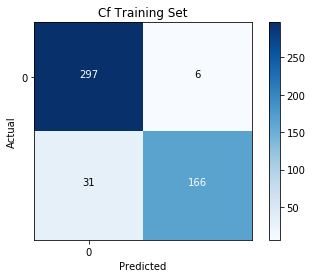

Acc: 0.989010989010989


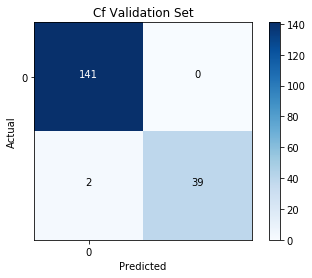

In [100]:
nn.X,nn.Y=x, y 
target=np.around(np.squeeze(y), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(x,y)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Training Set')

nn.X,nn.Y=xval, yval 
target=np.around(np.squeeze(yval), decimals=0).astype(np.int)
predicted=np.around(np.squeeze(nn.pred(xval,yval)), decimals=0).astype(np.int)
plotCf(target,predicted,'Cf Validation Set')

In [101]:
# We can see even more clearly that our validation set has perfect accuracy on its 183 samples. 
# As for the training set, there are 19 mistakes among the 500 samples.

#****  setting our prediction to be 1 if the sigmoid output gives a value above 0.5 is not really good. The 
# network should be really confident before giving a prediction of malignancy.
# create a new variable called threshold. It will control our confidence threshold, how close to 1 the
# output of the network needs to be before we decide that a tumor is malignant, By default we set it to 0.5

#can chage the value of threshold and see, what gives us better result and we can set threshold depending on
# the application

#lets take the value of threshold as 0.9

